# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
#!pip install pandas_datareader
from pandas_datareader import data
from azureml.core import Workspace, Dataset, Experiment, Run
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.train.automl.run import AutoMLRun
from azureml.core.model import Model, InferenceConfig
from azureml.core.environment import Environment
from azureml.core.webservice import AciWebservice

# Webservice
import urllib.request
import json
import os
import ssl

# Data Manipulation
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [4]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'MSFT-stock'

experiment=Experiment(ws, experiment_name)

# Data prepration

In [58]:
#download MSFT price data into DataFrame
MSFT = data.DataReader('MSFT', 'yahoo',start='1/1/2020')

#calculate the compound annual growth rate (CAGR) which 
#will give us our mean return input (mu) 
days = (MSFT.index[-1] - MSFT.index[0]).days
cagr = ((((MSFT['Adj Close'][-1]) / MSFT['Adj Close'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

#create a series of percentage returns and calculate 
#the annual volatility of returns
MSFT['Returns'] = MSFT['Adj Close'].pct_change()
vol = MSFT['Returns'].std()*np.sqrt(252) # #Number of trading days
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

 
MSFT.tail()

CAGR = 41.589999999999996%
Annual Volatility = 38.76%


,High,Low,Open,Close,Volume,Adj Close,Returns
Date,,,,,,,
2021-06-07,254.089996,249.809998,249.979996,253.809998,23079200.0,253.809998,0.012042
2021-06-08,256.010010,252.509995,255.160004,252.570007,22455000.0,252.570007,-0.004886
2021-06-09,255.529999,253.210007,253.809998,253.589996,17937600.0,253.589996,0.004038
2021-06-10,257.459991,253.669998,254.289993,257.239990,24563600.0,257.239990,0.014393
2021-06-11,258.489990,256.609985,257.989990,257.890015,18995100.0,257.890015,0.002527


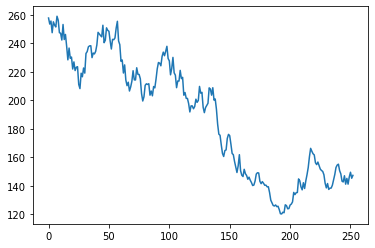

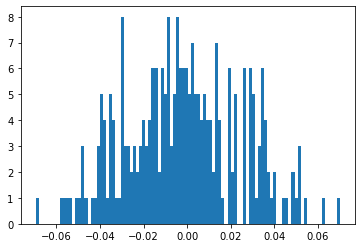

In [47]:
S = MSFT['Adj Close'][-1] #starting stock price (i.e. last available real stock price)
T = 252 #Number of trading days
mu = 0.2309 #Return
vol = 0.4259 #Volatility
#create list of daily returns using random normal distribution
daily_returns=np.random.normal((mu/T),vol/math.sqrt(T),T)+1
 
#set starting price and create price series generated by above random daily returns
price_list = [S]
for x in daily_returns:
    price_list.append(price_list[-1]*x)
#Generate Plots - price series and histogram of daily returns
plt.plot(price_list)
plt.show()
plt.hist(daily_returns-1, 100) #Note that we run the line plot and histogram separately, not simultaneously.
plt.show()

Text(0, 0.5, 'Adj Close')

<Figure size 432x288 with 0 Axes>

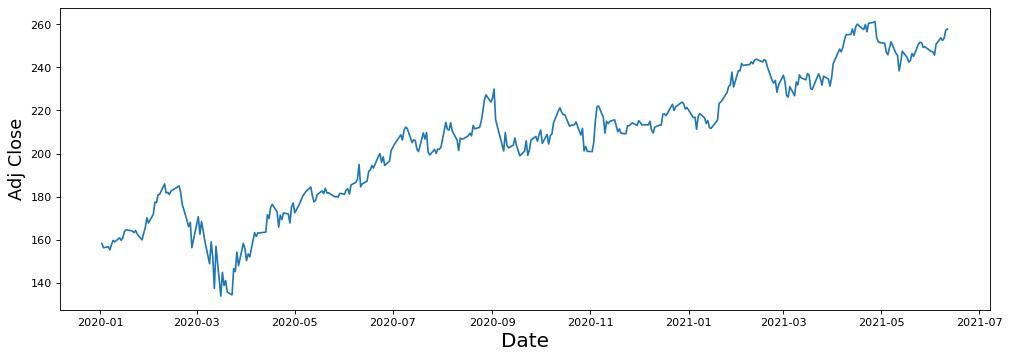

In [59]:
from matplotlib import pyplot as plt  
from matplotlib.pyplot import figure


MSFT = MSFT.reset_index()
X = MSFT[['Date','Adj Close']] 
fig = plt.figure( )
figure(figsize=(15,5), dpi=80)  
plt.plot(X['Date'], X['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel("Adj Close", fontsize=16)
 

In [60]:
X=X.reset_index(drop =True)
# Split the dataframe 
split_date ='2020-02-01'
X_precovid = X.loc[X['Date'] <= split_date]
X_covid = X.loc[X['Date'] > split_date]
X_precovid.set_index('Date', inplace=True)
X_covid.set_index('Date', inplace=True)

X_covid

,Adj Close
Date,
2020-02-03,171.758942
2020-02-04,177.412659
2020-02-05,177.195969
2020-02-06,180.869888
2020-02-07,181.126007
...,...
2021-06-07,253.809998
2021-06-08,252.570007
2021-06-09,253.589996


In [79]:
# Now that we have 2 dataset, we can register them into Azure ML

UPDATE_DATASET = True

if UPDATE_DATASET:    

    path = 'Data'

    try:
        os.mkdir(path,)
    except OSError as err:
        print(err)
    else:
        print('Directory %s succesfully created' %path)


    local_path = './Data/MSFT_prepared.csv'
    local_path_covid = './Data/MSFT_covid.csv'

    # Save the two dataset to csv
    X_precovid.to_csv(local_path)
    X_covid.to_csv(local_path_covid)


    # upload the local file to a datastore on the cloud

    # get the datastore to upload prepared data
    datastore = ws.get_default_datastore()

    # upload the local file from src_dir to the target_path in datastore
    datastore.upload(src_dir='Data', target_path='Data', overwrite=True, show_progress=True)

    # create a dataset referencing the cloud location
    dataset_prepared = Dataset.Tabular.from_delimited_files(path = [(datastore, (local_path))])
    dataset_covid = Dataset.Tabular.from_delimited_files(path = [(datastore, (local_path_covid))])


    # Register the Dataset

    dataset_prepared = dataset_prepared.register(workspace=ws,
                                 name='MSFT-stock cleaned',
                                 description='MSFT-stock pre-covid cleaned',
                                 create_new_version=True)

    dataset_covid = dataset_covid.register(workspace=ws,
                                 name='MSFT-stock post cleaned',
                                 description='MSFT-stock post-covid cleaned',
                                 create_new_version=True)

if not UPDATE_DATASET:
    dataset_prepared = Dataset.get_by_name(ws, name='MSFT-stock cleaned')
    dataset_covid = Dataset.get_by_name(ws, name='MSFT-stock post cleaned')

df_prepared = dataset_prepared.to_pandas_dataframe()
df_prepared = df_prepared.set_index('Date', inplace=False)
    
df_covid = dataset_covid.to_pandas_dataframe()
df_covid = df_covid.set_index('Date', inplace=False)


 

[Errno 17] File exists: 'Data'
Uploading an estimated of 2 files
Uploading Data/MSFT_covid.csv
Uploaded Data/MSFT_covid.csv, 1 files out of an estimated total of 2
Uploading Data/MSFT_prepared.csv
Uploaded Data/MSFT_prepared.csv, 2 files out of an estimated total of 2
Uploaded 2 files


In [80]:

# Check the dataset
dataset_prepared

{
  "source": [
    "('workspaceblobstore', './Data/MSFT_prepared.csv')"
  ],
  "definition": [
    "GetDatastoreFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes"
  ],
  "registration": {
    "id": "87512de4-eef7-4eda-8a0b-2a0e943a971b",
    "name": "MSFT-stock cleaned",
    "version": 2,
    "description": "MSFT-stock pre-covid cleaned",
    "workspace": "Workspace.create(name='quick-starts-ws-147101', subscription_id='2c48c51c-bd47-40d4-abbe-fb8eabd19c8c', resource_group='aml-quickstarts-147101')"
  }
}

In [81]:

# Check the DataFrame
df_prepared.tail()

,Adj Close
Date,
2020-01-27,159.840805
2020-01-28,162.973038
2020-01-29,165.514221
2020-01-30,170.182999
2020-01-31,167.671310


In [82]:
# Choose a name for your CPU cluster
amlcompute_cluster_name = "AMLTraining"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS3_V2',                                                           
                                                           max_nodes=4,
                                                          min_nodes = 1, idle_seconds_before_scaledown = 600)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)
# For a more detailed view of current AmlCompute status, use get_status().

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [85]:
# TODO: Put your automl settings here
automl_settings = {
    "experiment_timeout_minutes":60,
    "max_concurrent_iterations":4,
    "primary_metric": 'normalized_root_mean_squared_error',
    'time_column_name': 'Date'
}

# TODO: Put your automl config here
automl_config = AutoMLConfig(compute_target=compute_target,
                             task = "forecasting",
                             training_data=dataset_prepared,
                             label_column_name="Adj Close",
                             enable_early_stopping= True,
                             n_cross_validations=5,
                             featurization= 'auto',
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )

In [86]:
# TODO: Submit your experiment
# Submit the experiment
TRAIN = True

if TRAIN:
    run_autoML = experiment.submit(automl_config, show_output = True)
    run_autoML.wait_for_completion()
    
# If we already did the training, we can get our run by passing the run_id.
else:
    run_autoML = AutoMLRun(experiment, 'AutoML_dd070e91-6e7a-4509-996d-5215e118b403')

Submitting remote run.
No run_configuration provided, running on AMLTraining with default configuration
Running on remote compute: AMLTraining


Experiment,Id,Type,Status,Details Page,Docs Page
MSFT-stock,AutoML_dd070e91-6e7a-4509-996d-5215e118b403,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Short series handling
STATUS:       PASSED
DESCRIPTION:  Automated ML detected enough data points for each series in the input data to continue with training.
              

****************************************************************************************************

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

***************

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [87]:
RunDetails(run_autoML).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [ ]:

# Retrieve and save your best automl model.

best_run_autoML, fitted_model_autoML = run_autoML.get_output()

print(best_run_autoML.id)

print('MAE of best autoML model = {} and RMSE = {}'.format(best_run_autoML.get_metrics()['mean_absolute_error'], best_run_autoML.get_metrics()['root_mean_squared_error']))

In [ ]:
#TODO: Save the best model

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

TODO: In the cell below, send a request to the web service you deployed to test it.

TODO: In the cell below, print the logs of the web service and delete the service